<a href="https://colab.research.google.com/github/Ravimk07/Tensorflow_colab_examples/blob/master/Test2bukhari_segmentation_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import h5py
import numpy as np
from PIL import Image
from matplotlib import  pyplot as plt
%matplotlib inline  

# Check the current drive location

In [0]:
# load the data by uploding on drive
os.getcwd()

'/content'

In [15]:
!rm -rf data(1).zip

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `rm -rf data(1).zip'


# Upload the database on drive

In [16]:
from google.colab import files
uploaded = files.upload()

Saving data1.zip to data1.zip


# Save the images on drive

In [17]:
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print('Saved file', name)

Saved file data1.zip


In [0]:
os.listdir('/content/')

['.config', 'data.zip', 'sample_data']

# Extracting the zip files to this current location

In [0]:

# This is for extracting the files
import zipfile
path_to_zip_file = 'data1.zip'
directory_to_extract_to = ''
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

In [19]:
os.listdir('/content/')

['.config', 'data (1).zip', 'data1.zip', 'data', 'data1', 'sample_data']

# Check all the images with gt

In [20]:

os.listdir('/content/data1')

['image', 'gt']

In [0]:
original_imgs_train = "/content/data1/image" 
groundTruth_imgs_train = "/content/data1/gt" 

In [0]:
height = 864
width = 896

imgs_dir = original_imgs_train + "/2.jpg"
#imgs_dir = groundTruth_imgs_train + "/2_label.png"

img = Image.open(imgs_dir)
img_arr = np.asarray(img)

(1906, 896)


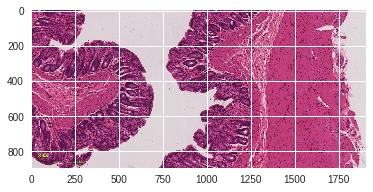

In [23]:
print(img.size)
plt.imshow(img)

(896, 1906, 3)
uint8


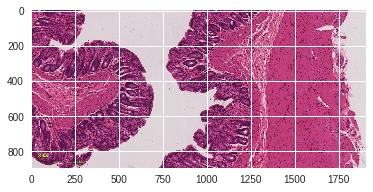

In [24]:
print(img_arr.shape)
print(img_arr.dtype)
plt.imshow(img_arr)

In [26]:
# Load data from directory
import numpy as np
import os
from PIL import Image
Nimgs = 3
channels = 3
height, width = 896,1906 

imgs_dir =  "/content/data1/image"
groundTruth_dir = "/content/data1/gt"
imgs = np.empty((Nimgs,height,width,channels))
groundTruth = np.empty((Nimgs,height,width))#,4))

# TODO: Cut image into 864, 1872
for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #img
            print("original image: " + files[i])
            img = Image.open(os.path.join(imgs_dir,files[i]))
            imgs[i] = np.asarray(img)
            #gt
            groundTruth_name = files[i][0:1] + "_label.png"
            print("ground truth name: " + groundTruth_name)
            g_truth = Image.open(os.path.join(groundTruth_dir, groundTruth_name))
            g_truth = g_truth.convert('L')
            g_truth = np.asarray(g_truth)
            unique = np.unique(g_truth.reshape(-1, 1), axis=0)
            np.putmask(g_truth, g_truth==unique[0], 0.0)
            np.putmask(g_truth, g_truth==unique[1], 1.0)
            np.putmask(g_truth, g_truth==unique[2], 2.0)
            np.putmask(g_truth, g_truth==unique[3], 3.0)
            groundTruth[i] = g_truth

imgs=imgs.astype('uint8')
groundTruth=groundTruth.astype('uint8')

original image: 3.jpg
ground truth name: 3_label.png
original image: 2.jpg
ground truth name: 2_label.png


(3, 896, 1906, 3)


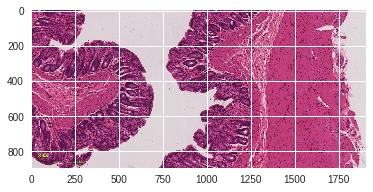

In [27]:
i=1
print(imgs.shape)
plt.imshow(imgs[i])

(3, 896, 1906)


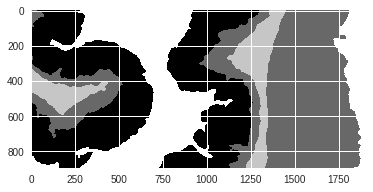

In [28]:
print(groundTruth.shape)
plt.imshow(groundTruth[i])

In [0]:
# Nimgs,height,width,channels
imgs = imgs[:,0:864,0:1872]  #cut bottom and top so now it is 565*565
groundTruth = groundTruth[:,0:864,0:1872] 

(3, 864, 1872, 3)


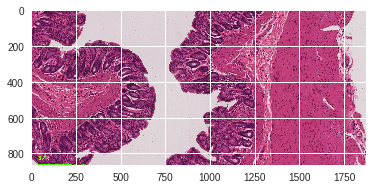

In [30]:
print(imgs.shape)
plt.imshow(imgs[i])

(3, 864, 1872)


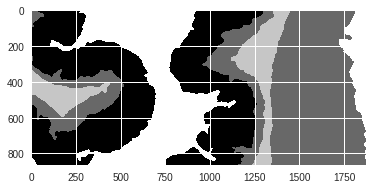

In [31]:
print(groundTruth.shape)
plt.imshow(groundTruth[i])

#plt.subplot(111)
#plt.imshow(groundTruth[1])

In [0]:
# Source: https://gist.github.com/dwf/366247
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib
import matplotlib.pyplot as plt

def frac_eq_to(image, value=0):
    return (image == value).sum() / float(np.prod(image.shape))

def extract_patches(image, groundtruth, patchshape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1):
    """
    Given an image (grountruth), extract patches of a given shape with a certain
    amount of allowed overlap between patches, using a heuristic to
    ensure maximum coverage.

    If cropvalue is specified, it is treated as a flag denoting a pixel
    that has been cropped. Patch will be rejected if it has more than
    crop_fraction_allowed * prod(patchshape) pixels equal to cropvalue.
    Likewise, patches will be rejected for having more overlap_allowed
    fraction of their pixels contained in a patch already selected.
    """
    jump_cols = int(patchshape[1] * overlap_allowed)
    jump_rows = int(patchshape[0] * overlap_allowed)
    
    # Restrict ourselves to the rectangle containing non-cropped pixels
    #if cropvalue is not None:
        # TODO: cropvalue is the preferred class to be extracted i.e. 0,1,2,3
        # rows, cols = np.where(image != cropvalue)
        # TODO: use rows, and cols to guide extraction
    rows, cols = np.where(groundtruth == cropvalue)
        #rows.sort(); cols.sort()
        #active =  image[rows[0]:rows[-1], cols[0]:cols[-1]]
    #else:
    active_img = image
    active_gt = groundtruth

    rowstart = 0; colstart = 0

    # Array tracking where we've already taken patches.
    covered = np.zeros(active_gt.shape, dtype=bool)
    patches_imgs = []
    patches_gt = []

    while rowstart < active_gt.shape[0] - patchshape[0]:
        # Record whether or not e've found a patch in this row, 
        # so we know whether to skip ahead.
        got_a_patch_this_row = False
        colstart = 0
        while colstart < active_gt.shape[1] - patchshape[1]:
            # Slice tuple indexing the region of our proposed patch
            region = (slice(rowstart, rowstart + patchshape[0]),
                      slice(colstart, colstart + patchshape[1]))
            
            # The actual pixels in that region.
            patch = active_gt[region]

            # The current mask value for that region.
            cover_p = covered[region]
            if cropvalue is None or \
               frac_eq_to(patch, cropvalue) <= crop_fraction_allowed and \
               frac_eq_to(cover_p, True) <= overlap_allowed:
                # Accept the patch.
                patches_imgs.append(active_img[region])
                patches_gt.append(active_gt[region])
                
                # Mask the area.
                # TODO: Return convered
                covered[region] = True
                
                # Jump ahead in the x direction.
                colstart += jump_cols
                got_a_patch_this_row = True
                #print "Got a patch at %d, %d" % (rowstart, colstart)
            else:
                # Otherwise, shift window across by one pixel.
                colstart += 1

        if got_a_patch_this_row:
            # Jump ahead in the y direction.
            rowstart += jump_rows
        else:
            # Otherwise, shift the window down by one pixel.
            rowstart += 1

    # Return a 3D array of the patches with the patch index as the first
    # dimension (so that patch pixels stay contiguous in memory, in a 
    # C-ordered array).
    return (np.concatenate([pat[np.newaxis, ...] for pat in patches_imgs], axis=0), np.concatenate([pat[np.newaxis, ...] for pat in patches_gt], axis=0),covered)
#     return (patches_imgs,patches_gt,covered)

def plot_patches(patches, fignum=None, low=0, high=0):
    """
    Given a stack of 2D patches indexed by the first dimension, plot the
    patches in subplots. 

    'low' and 'high' are optional arguments to control which patches
    actually get plotted. 'fignum' chooses the figure to plot in.
    """
    try:
        istate = plt.isinteractive()
        plt.ioff()
        if fignum is None:
            fig = plt.gcf()
        else:
            fig = plt.figure(fignum)
        if high == 0:
            high = len(patches)
        pmin, pmax = patches.min(), patches.max()
        dims = np.ceil(np.sqrt(high - low))
        for idx in range(high - low):
            spl = plt.subplot(dims, dims, idx + 1)
            ax = plt.axis('off')
            im = plt.imshow(patches[idx], cmap=matplotlib.cm.gray)
            cl = plt.clim(pmin, pmax)
        plt.show()
    finally:
        plt.interactive(istate)

def filter_patches(patches, min_mean=0.0, min_std=0.0):
    """
    Filter patches by some criterion on their mean and variance.
    
    Takes patches, a 3-dimensional stack of image patches (where
    the first dimension indexes the patch), and a minimum
    mean and standard deviation. Returns a stack of all the 
    patches that satisfy both of these criteria.
    """
    patchdim = np.prod(patches.shape[1:])
    patchvectors = patches.reshape(patches.shape[0], patchdim)
    means = patchvectors.mean(axis=1)
    stdevs = patchvectors.std(axis=1)
    indices = (means > min_mean) & (stdevs > min_std)
    return patches[indices]

def extract_patches_from_dir(directory, patchsize, 
                             smoothing=None, overlap_allowed=0.5,
                             cropvalue=None, crop_fraction_allowed=0.1,
                             min_mean=0, min_std=0):
    """
    Extract patches from an entire directory of images.
    
    If `smoothing` is not None, it is used as the standard deviation of a
    Gaussian filter applied to the image before extracting patches.
    
    `patchsize`, `overlap_allowed`, `cropvalue` and `crop_fraction_allowed`
    are passed along to `extract_patches()`. `min_mean` and `min_std` are
    passed along to `filter_patches()`.
    """
    output = {}
    for fname in os.listdir(directory):
        if fname[-4:] == '.png':
            outname = fname.replace('.','_').replace('-','_')
            assert outname not in output
            image = plt.imread(os.path.join(directory, fname))
            if smoothing is not None:
                image = ndimage.gaussian_filter(image, smoothing)
            # Extract patches from the image.
            output[outname] = extract_patches(image, patchsize,
                                              overlap_allowed,
                                              cropvalue, crop_fraction_allowed)

            # Filter the patches that don't meet our standards.
            output[outname] = filter_patches(output[outname], min_std=min_std,
                                             min_mean=min_mean)
    return output

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam

Using TensorFlow backend.


In [33]:
# Extract 
patchsize=48,48
overlap_allowed=0.6
cropvalue=[0,1,2,3]
crop_fraction_allowed=0.10

patches_imgs_train = np.empty((0,48,48,3))
patches_masks_train = np.empty((0,48,48))  # each pixel value could be either 0,1,2,3
    
for i in range(imgs.shape[0]-1): #  train on image 0 and 1
    for j in range(4): # 4 classes
        p_imgs,p_gt,covered = extract_patches(imgs[i], groundTruth[i], patchsize,
                                              overlap_allowed,
                                              cropvalue[j], crop_fraction_allowed)
        print('p_imgs.shape: ', p_imgs.shape)
        patches_imgs_train = np.append(patches_imgs_train,p_imgs,axis=0)
        patches_masks_train = np.append(patches_masks_train,p_gt,axis=0)

patches_imgs_train=patches_imgs_train.astype('uint8')
patches_masks_train=patches_masks_train.astype('uint8')

p_imgs.shape:  (1221, 48, 48, 3)
p_imgs.shape:  (1446, 48, 48, 3)
p_imgs.shape:  (944, 48, 48, 3)
p_imgs.shape:  (1166, 48, 48, 3)
p_imgs.shape:  (1237, 48, 48, 3)
p_imgs.shape:  (1504, 48, 48, 3)
p_imgs.shape:  (1017, 48, 48, 3)
p_imgs.shape:  (1007, 48, 48, 3)


(9542, 48, 48, 3)


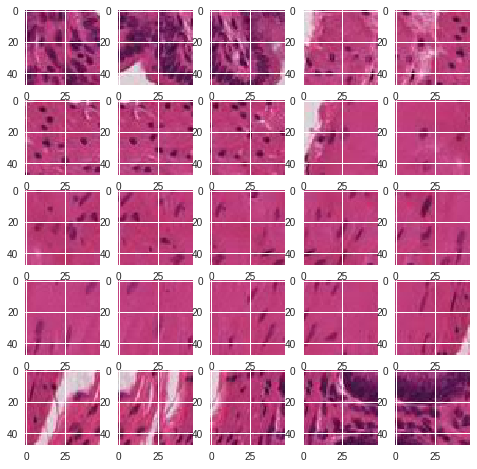

In [34]:
# Plot patches_imgs_train
print(patches_imgs_train.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
j=50
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(patches_imgs_train[i+j])
plt.show()

(9542, 48, 48)


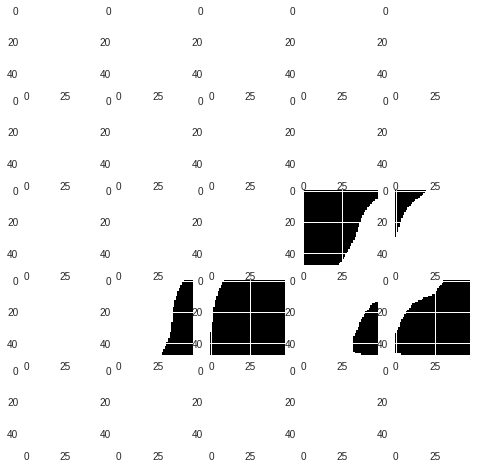

In [35]:
# Plot patches_masks_train
print(patches_masks_train.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
j=200
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(patches_masks_train[i+j])
plt.show()

In [0]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [37]:
import numpy as np

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD

# import sys
# sys.path.insert(0, './lib/')
# from help_functions import *
n_classes = 4

#Define the neural network
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(n_classes, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((n_classes,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(input=inputs, output=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [38]:
#training settings
import os
N_epochs = 5
batch_size = 32
name_experiment = 'Segmentation_ravi_unet'

filename = './'+name_experiment+'/'+"sample_input_imgs"
if not os.path.exists(filename):
    os.makedirs(filename)
    
#========= Save a sample of what you're feeding to the neural network ==========
# N_sample = 5 #min(patches_imgs_train.shape[0],40)
# visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),filename)#.show() # 
# visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),filename)#.show() # [0:N_sample,:,:,:]

#=========== Construct and save the model arcitecture =====
n_ch = 3#patches_imgs_train.shape[1]
patch_height = 48#patches_imgs_train.shape[2]
patch_width = 48#patches_imgs_train.shape[3]
model = get_unet(n_ch, patch_height, patch_width)  #the U-net model
print("Check: final output of the network:")
print(model.output_shape)
plot_model(model, to_file='./'+name_experiment+'/'+name_experiment + '_model.png',show_shapes=True)   #check how the model looks like
json_string = model.to_json()
open('./'+name_experiment+'/'+name_experiment +'_architecture.json', 'w').write(json_string)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Check: final output of the network:
(None, 2304, 4)


10465

In [0]:
#prepare the mask in the right shape for the Unet
def masks_Unet(masks):
    assert (len(masks.shape)==4)  #4D arrays
    assert (masks.shape[1]==1 )  #check the channel is 1
    im_h = masks.shape[2]
    im_w = masks.shape[3]
    masks = np.reshape(masks,(masks.shape[0],im_h*im_w))
    new_masks = np.empty((masks.shape[0],im_h*im_w,4)) # original is 2
    for i in range(masks.shape[0]):
        for j in range(im_h*im_w):
            if  masks[i,j] == 0:
                new_masks[i,j,0]=1
                new_masks[i,j,1]=0
                new_masks[i,j,2]=0
                new_masks[i,j,3]=0
            elif masks[i,j] == 1:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=1
                new_masks[i,j,2]=0
                new_masks[i,j,3]=0
            elif masks[i,j] == 2:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=0
                new_masks[i,j,2]=1
                new_masks[i,j,3]=0
            elif masks[i,j] == 3:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=0
                new_masks[i,j,2]=0
                new_masks[i,j,3]=1
    return new_masks

In [40]:
patches_imgs_train.shape, patches_masks_train.shape

((9542, 48, 48, 3), (9542, 48, 48))

In [41]:
np.moveaxis(patches_imgs_train,3,1).shape, np.expand_dims(patches_masks_train,axis=1).shape

((9542, 3, 48, 48), (9542, 1, 48, 48))

In [42]:
#============  Training ==================================
checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+name_experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

# Channel first
patches_masks_train_flatten = masks_Unet(np.expand_dims(patches_masks_train,axis=1))  #reduce memory consumption
history = model.fit(np.moveaxis(patches_imgs_train,3,1), 
                    patches_masks_train_flatten, 
                    nb_epoch=N_epochs, 
                    batch_size=batch_size, 
                    verbose=2, shuffle=True, 
                    validation_split=0.1, 
                    callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 8587 samples, validate on 955 samples
Epoch 1/5
 - 2417s - loss: 1.4083 - acc: 0.2299 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00001: val_loss improved from inf to 1.38629, saving model to ./Segmentation_ravi_unet/Segmentation_ravi_unet_best_weights.h5
Epoch 2/5
 - 2415s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00002: val_loss did not improve from 1.38629
Epoch 3/5
 - 2412s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00003: val_loss did not improve from 1.38629
Epoch 4/5
 - 2412s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00004: val_loss did not improve from 1.38629
Epoch 5/5
 - 2423s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00005: val_loss did not improve from 1.38629


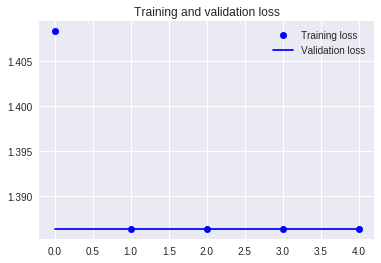

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ = range(N_epochs)
plt.figure()
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

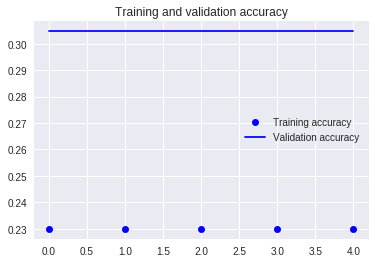

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_ = range(N_epochs)
plt.figure()
plt.plot(epochs_, acc, 'bo', label='Training accuracy')
plt.plot(epochs_, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [0]:
#Divide all the full_imgs in pacthes
def extract_ordered(full_imgs, patch_h, patch_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    N_patches_h = int(img_h/patch_h) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_h) +" patches in height, with about " +str(img_h%patch_h) +" pixels left over")
    N_patches_w = int(img_w/patch_w) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_w) +" patches in width, with about " +str(img_w%patch_w) +" pixels left over")
    print("number of patches per image: " +str(N_patches_h*N_patches_w))
    N_patches_tot = (N_patches_h*N_patches_w)*full_imgs.shape[0]
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))

    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range(N_patches_h):
            for w in range(N_patches_w):
                patch = full_imgs[i,:,h*patch_h:(h*patch_h)+patch_h,w*patch_w:(w*patch_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches

In [0]:
#Load the original data and return the extracted patches for training/testing
def get_data_testing(DRIVE_test_imgs_original, DRIVE_test_groudTruth, Imgs_to_test, patch_height, patch_width):
    ### test
    test_imgs = DRIVE_test_imgs_original #load_hdf5(DRIVE_test_imgs_original)
    test_masks = DRIVE_test_groudTruth # load_hdf5(DRIVE_test_groudTruth)
    
#     test_imgs = my_PreProc(test_imgs_original)
#     test_masks = test_masks/255.

    #extend both images and masks so they can be divided exactly by the patches dimensions
#     test_imgs = test_imgs[0:Imgs_to_test,:,:,:]
#     test_masks = test_masks[0:Imgs_to_test,:,:,:]
#     test_imgs = paint_border(test_imgs,patch_height,patch_width)
#     test_masks = paint_border(test_masks,patch_height,patch_width)

#     data_consistency_check(test_imgs, test_masks)

    #check masks are within 0-1
#     assert(np.max(test_masks)==1  and np.min(test_masks)==0)

#     print "\ntest images/masks shape:"
#     print test_imgs.shape
#     print "test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs))
#     print "test masks are within 0-1\n"

    #extract the TEST patches from the full images
    patches_imgs_test = extract_ordered(test_imgs,patch_height,patch_width)
    patches_masks_test = extract_ordered(test_masks,patch_height,patch_width)
#     data_consistency_check(patches_imgs_test, patches_masks_test)

#     print "\ntest PATCHES images/masks shape:"
#     print patches_imgs_test.shape
#     print "test PATCHES images range (min-max): " +str(np.min(patches_imgs_test)) +' - '+str(np.max(patches_imgs_test))

    return patches_imgs_test, patches_masks_test


In [0]:
def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    # TODO: pred.shape = 702, 2304, 4
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,4)
    assert (pred.shape[2]==4 )  #check the classes are 4
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1] # not suitable for classes
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i,pix]=1
                else:
                    pred_images[i,pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images


In [0]:
def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    # TODO: pred.shape = 702, 2304, 4
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,4)
    assert (pred.shape[2]==4 )  #check the classes are 4
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1] # not suitable for classes
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=np.where(pred[i,pix,:]==np.max(pred[i,pix,:]))[0][0]
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images


In [0]:
#Recompone the full images with the patches
def recompone(data,N_h,N_w):
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    assert(len(data.shape)==4)
    N_pacth_per_img = N_w*N_h
    print('data.shape: ',data.shape)
    print('N_pacth_per_img: ', N_pacth_per_img)
    assert(data.shape[0]%N_pacth_per_img == 0)
    N_full_imgs = data.shape[0]/N_pacth_per_img
    patch_h = data.shape[2]
    patch_w = data.shape[3]
    N_pacth_per_img = N_w*N_h
    #define and start full recompone
    full_recomp = np.empty((int(N_full_imgs),data.shape[1],int(N_h*patch_h),int(N_w*patch_w)))
    k = 0  #iter full img
    s = 0  #iter single patch
    while (s<data.shape[0]):
        #recompone one:
        single_recon = np.empty((data.shape[1],N_h*patch_h,N_w*patch_w))
        for h in range(N_h):
            for w in range(N_w):
                single_recon[:,h*patch_h:(h*patch_h)+patch_h,w*patch_w:(w*patch_w)+patch_w]=data[s]
                s+=1
        full_recomp[k]=single_recon
        k+=1
    assert (k==N_full_imgs)
    return full_recomp


In [0]:
# Data for testing
img = np.asarray(Image.open("/content/1.jpg"))
gt = np.asarray(Image.open("/content/1_label.png").convert('L'))
unique = np.unique(gt.reshape(-1, 1), axis=0)
np.putmask(gt, gt==unique[0], 0.0)
np.putmask(gt, gt==unique[1], 1.0)
np.putmask(gt, gt==unique[2], 2.0)
np.putmask(gt, gt==unique[3], 3.0)

(896, 1906, 3)


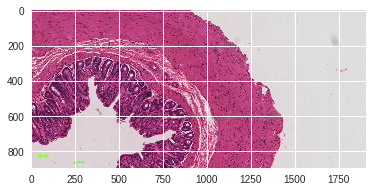

In [52]:
print(img.shape)
plt.imshow(img)

(896, 1906)


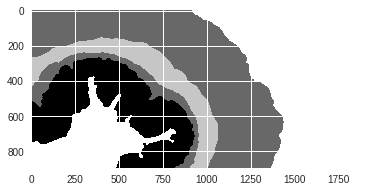

In [53]:
print(gt.shape)
plt.imshow(gt)

In [54]:
np.expand_dims(np.moveaxis(img,2,0),0).shape, np.expand_dims(np.expand_dims(gt,0),0).shape

((1, 3, 896, 1906), (1, 1, 896, 1906))

In [55]:
# from extract_patches import *
patches_imgs_test, patches_masks_test = get_data_testing(
        DRIVE_test_imgs_original = np.expand_dims(np.moveaxis(img,2,0),0),  #original
        DRIVE_test_groudTruth = np.expand_dims(np.expand_dims(gt,0),0),  #masks
        Imgs_to_test = 1,
        patch_height = 48,
        patch_width = 48,
    )

number of patches per image: 702
number of patches per image: 702


In [56]:
patches_imgs_test.shape, patches_masks_test.shape

((702, 3, 48, 48), (702, 1, 48, 48))

In [57]:
# Recompone and plot image back
img_rc = recompone(patches_imgs_test,18,39)  # originals
gt_rc = recompone(patches_masks_test,18,39)  #masks  [???]

img_rc=np.moveaxis(img_rc.astype('uint8'),1,-1)
gt_rc=np.squeeze(np.moveaxis(gt_rc.astype('uint8'),1,-1),-1)

data.shape:  (702, 3, 48, 48)
N_pacth_per_img:  702
data.shape:  (702, 1, 48, 48)
N_pacth_per_img:  702


(1, 864, 1872, 3)


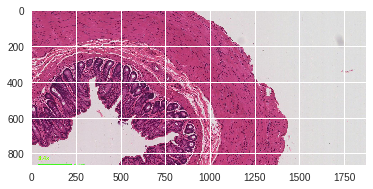

In [58]:
print(img_rc.shape)
plt.imshow(img_rc[0])

(1, 864, 1872)
[[0]
 [1]
 [2]
 [3]]


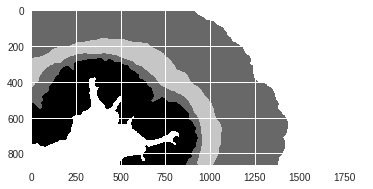

In [59]:
print(gt_rc.shape)
plt.imshow(gt_rc[0])
print(np.unique(gt_rc.reshape(-1,1),axis=0))

In [60]:
from keras.models import model_from_json

#================ Run the prediction of the patches ==================================
#Load the saved model
path_experiment = './'
model = model_from_json(open('./'+name_experiment+'/'+name_experiment +'_architecture.json').read())
model.load_weights('./'+name_experiment+'/'+name_experiment +'_best_weights.h5')
#Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)
print("predicted images size :")
print(predictions.shape)

predicted images size :
(702, 2304, 4)


In [0]:
#===== Convert the prediction arrays in corresponding images
patch_height, patch_width = 48,48
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "threshold") # actually to patch, original threshold

In [62]:
patches_imgs_test.shape

(702, 3, 48, 48)

In [63]:
pred_patches.shape

(702, 1, 48, 48)

In [64]:
np.unique(pred_patches.reshape(-1,1),axis=0)

array([[0.]])

In [65]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = recompone(pred_patches,18,39)       # predictions
orig_imgs = recompone(patches_imgs_test,18,39)  # originals
gtruth_masks = recompone(patches_masks_test,18,39)  #masks 

pred_imgs=pred_imgs.astype('uint8')
orig_imgs=orig_imgs.astype('uint8')
gtruth_masks=gtruth_masks.astype('uint8')

data.shape:  (702, 1, 48, 48)
N_pacth_per_img:  702
data.shape:  (702, 3, 48, 48)
N_pacth_per_img:  702
data.shape:  (702, 1, 48, 48)
N_pacth_per_img:  702


In [66]:
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))

Orig imgs shape: (1, 3, 864, 1872)
pred imgs shape: (1, 1, 864, 1872)
Gtruth imgs shape: (1, 1, 864, 1872)


In [67]:
np.unique(pred_imgs.reshape(-1,1),axis=0)

array([[0]], dtype=uint8)

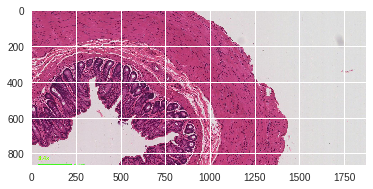

In [68]:
plt.imshow(np.moveaxis(orig_imgs[0],0,-1))

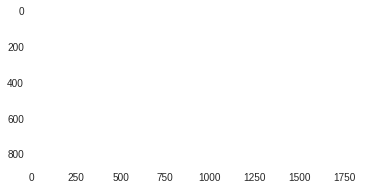

In [69]:
plt.imshow(pred_imgs[0][0])